In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: 0.1297936908114197, node: C[C@@H](CC1CCCC1)[NH+]1CCN(C(=O)NCCS(=O)(=O)c2cccc(OC)c2)C1
1- time: 0.12, count_rollouts: 3, reward: 0.34103563601805853, node: Nc1ccc(-c2cccc(C)c2)c(C)c1
2- time: 0.22, count_rollouts: 5, reward: 0.25685468828601077, node: Fc1ccccc1CNC(=O)c1ccc(C#N)cc1
3- time: 0.25, count_rollouts: 6, reward: 0.2241676644270794, node: [NH3+]Cc1ccc(OCCOc2nc(C(F)F)cs2)cc1
4- time: 0.55, count_rollouts: 13, reward: 0.28765515179450707, node: N#CCCCN(C(=O)[C@@H]1CCOC1)c1ccc(N2CCCC2)cc1
5- time: 0.75, count_rollouts: 17, reward: 0.21971820430576586, node: NC(=O)c1ccc([C@@H]2CNC(=O)N(Cc3ccc(F)cc3)C2)cc1
6- time: 0.90, count_rollouts: 20, reward: 0.21662290218781174, node: c1ccc(CN2C(=O)C(=O)N(c3cccc(F)c3)CC2)cc1
7- time: 0.95, count_rollouts: 21, reward: 0.32124073337954767, node: Clc1cccc(N2CCCCC2)c1
8- time: 1.19, count_rollouts: 27, reward: 0.3137234355465625, node: ClC(=O)COc1ccc(Cl)cc1Br
9- time: 1.27, count_rollou

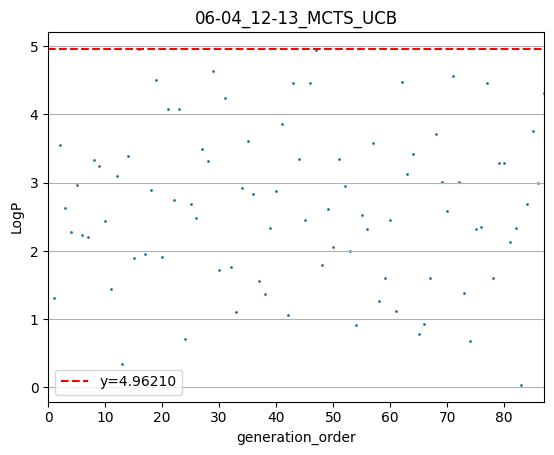

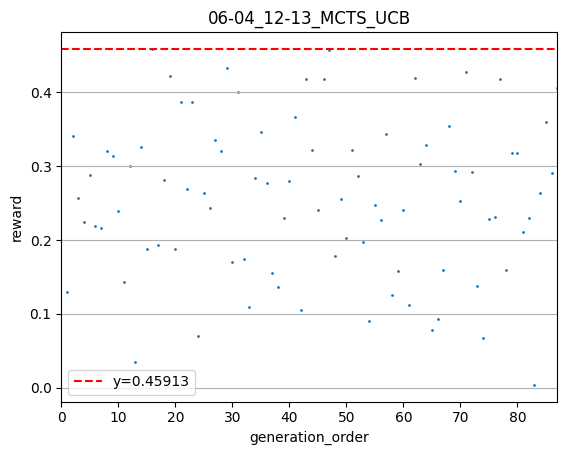

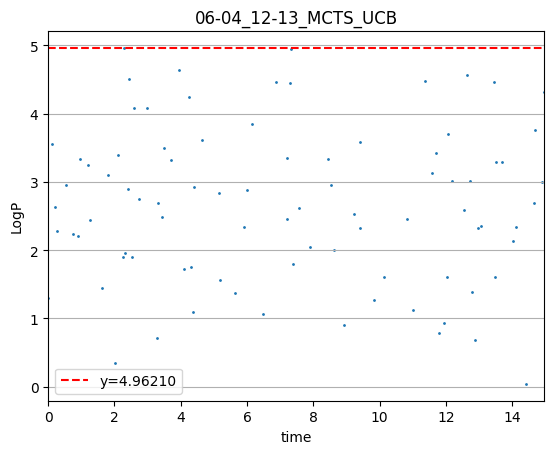

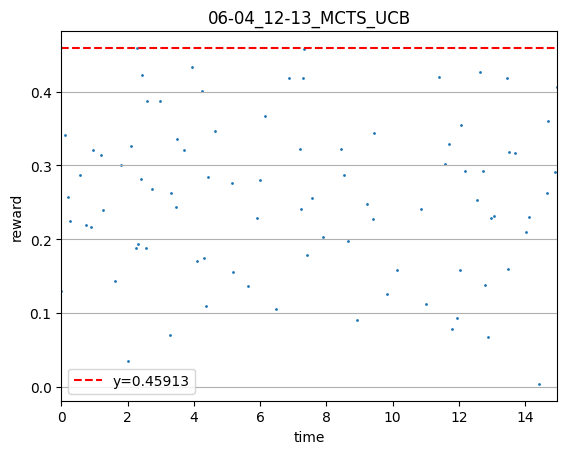

Search is completed.


In [12]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)